In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
from sklearn.metrics import balanced_accuracy_score

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
import pandas as pd
import pickle

In [5]:
import torch.utils.data as utils

In [6]:
import numpy as np

In [7]:
from barbar import Bar

In [8]:
torch.manual_seed(27)

### STEP 2: LOADING DATASET 

In [9]:
class CattleSoundDataset(Dataset):
    """ FreeSound dataset."""

    # Initialize your data, download, etc.
    def __init__(self, X, y):
        
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return (self.x_data[index], self.y_data[index])

    def __len__(self):
        return self.len

In [10]:
X_train = np.load('data/train_test/X_mel_train.npy')

In [11]:
X_test = np.load('data/train_test/X_mel_test.npy')

In [12]:
y_train = np.load('data/train_test/y_mel_train.npy')

In [13]:
y_test = np.load('data/train_test/y_mel_test.npy')

In [14]:
print('X_train:', X_train.shape)

print('X_test:', X_test.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (1072, 60, 35)
X_test: (460, 60, 35)
y_train: (1072,)
y_test: (460,)


In [15]:
train_dataset = CattleSoundDataset(X_train, y_train)

In [16]:
test_dataset = CattleSoundDataset(X_test, y_test)

### STEP 2: MAKING DATASET ITERABLE

In [17]:
batch_size = 32
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [18]:
num_epochs

89

In [19]:
transformations = transforms.Compose([transforms.ToTensor()])

In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size= batch_size, 
                                           shuffle=True)

In [21]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### STEP 3: CREATE MODEL CLASS

In [22]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.max_pool = nn.MaxPool2d(2)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        return x

In [23]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=32),
            ConvBlock(in_channels=32, out_channels=64),
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(7680, 1024),
            nn.PReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.1),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        #x = torch.mean(x, dim=3)
        #x, _ = torch.max(x, dim=2)
        out = self.fc(out)
        return out

### STEP 4: INSTANTIATE MODEL CLASS

In [24]:
model = CNNModel(num_classes=3)

In [25]:
#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()

### STEP 5: INSTANTIATE LOSS CLASS

In [26]:
criterion = nn.CrossEntropyLoss().cuda()

### STEP 6: INSTANTIATE OPTIMIZER CLASS

In [27]:
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### STEP 7: TRAIN THE MODEL

In [30]:
niter = 0
history = pd.DataFrame()
train_acc = []
val_acc = []
for epoch in range(num_epochs):
    print('Epoch: {}'.format(epoch+1))
    
    for i, (images, labels) in enumerate(Bar(train_loader)):

        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = Variable(images.unsqueeze(1).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.unsqueeze(1))
            labels = Variable(labels)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        #images = images.unsqueeze(1).type(torch.FloatTensor).cuda()
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        niter += 1
        
        if niter % 500 == 0:
            # Calculate Accuracy         
            y_pred = []
            y_test = []
            y_train = []
            
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.unsqueeze(1).cuda())
                else:
                    images = Variable(images.unsqueeze(1))
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
             
                if torch.cuda.is_available():
                    y_pred += predicted.cpu().numpy().tolist()
                    y_test += labels.cpu().numpy().tolist()
                    
                else:
                    y_pred += predicted.numpy()
                    y_test += labels.numpy()
            

            
            accuracy = balanced_accuracy_score(y_test, y_pred)
            val_acc.append(accuracy)
            
            
            # Print Loss
            print('\nIteration: {}. Loss: {}. Balanced Accuracy: {}'.format(niter, loss.data, accuracy))
            
            y_pred = []
            # Iterate through train dataset
            for images, labels in train_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = Variable(images.unsqueeze(1).cuda())
                else:
                    images = Variable(images.unsqueeze(1))
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
             
                if torch.cuda.is_available():
                    y_pred += predicted.cpu().numpy().tolist()
                    y_train += labels.cpu().numpy().tolist()
                else:
                    y_pred += predicted.numpy()
                    y_train += labels.numpy()
            

            
            accuracy = balanced_accuracy_score(y_train, y_pred)
            train_acc.append(accuracy)

history['val_acc'] = val_acc
history['acc'] = train_acc

Epoch: 1
1072/1072: [===============================>] - ETA 0.0s
Epoch: 2
1072/1072: [===============================>] - ETA 0.0s
Epoch: 3
1072/1072: [===============================>] - ETA 0.0s
Epoch: 4
1072/1072: [===============================>] - ETA 0.0s
Epoch: 5
1072/1072: [===============================>] - ETA 0.0s
Epoch: 6
1072/1072: [===============================>] - ETA 0.0s
Epoch: 7
1072/1072: [===============================>] - ETA 0.0s
Epoch: 8
1072/1072: [===============================>] - ETA 0.0s
Epoch: 9
1072/1072: [===============================>] - ETA 0.0s
Epoch: 10
1072/1072: [===============================>] - ETA 0.0s
Epoch: 11
1072/1072: [===============================>] - ETA 0.0s
Epoch: 12
1072/1072: [===============================>] - ETA 0.0s
Epoch: 13
1072/1072: [===============================>] - ETA 0.0s
Epoch: 14
1072/1072: [===============================>] - ETA 0.0s
Epoch: 15
 768/1072: [=====================>..........] - ETA 0.1s
Iter

In [31]:
%matplotlib inline 
import matplotlib.pyplot as plt

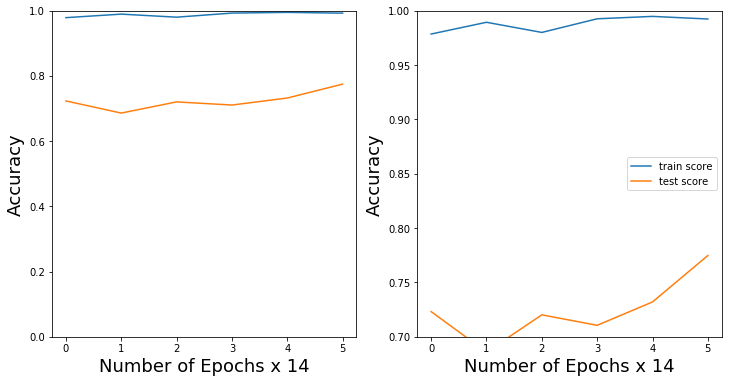

In [32]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(0, len(history)), history['acc'], label='train score')
axarr[0].plot(range(0, len(history)), history['val_acc'], label='test score')
axarr[0].set_xlabel('Number of Epochs x 14', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(0, len(history)), history['acc'], label='train score')
axarr[1].plot(range(0, len(history)), history['val_acc'], label='test score')
axarr[1].set_xlabel('Number of Epochs x 14', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
axarr[1].set_ylim([0.7,1])
plt.legend()
plt.show()